In [24]:
import numpy as np
import pandas as pd
import ipyvolume as ipv

import matplotlib.pylab as plt
%matplotlib inline


from tyssue import config
from tyssue import Monolayer, Sheet
from tyssue import PlanarGeometry as geom
from tyssue.generation import extrude
from tyssue.dynamics import model_factory, effectors, units
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.effectors import AbstractEffector
from tyssue.utils import to_nd

from tyssue.topology.base_topology import collapse_edge, remove_face
from tyssue.topology.sheet_topology import split_vert as sheet_split
from tyssue.topology.bulk_topology import split_vert as bulk_split

from tyssue.draw import sheet_view, highlight_cells

from tyssue.core.sheet import get_opposite

from tyssue.generation import single_cell
from tyssue.core.objects import _is_closed_cell
from tyssue.topology import condition_4i, condition_4ii
from tyssue.utils.connectivity import edge_in_face_connectivity
#from tyssue.topology import connectivity

In [25]:
sheet = Sheet.planar_sheet_2d('flat', 30, 30, 1, 1, noise=0.2)
to_cut = sheet.cut_out([(0.1, 6), (0.1, 6)])
sheet.remove(to_cut, trim_borders=True)
sheet.sanitize(trim_borders=True)
geom.center(sheet)
geom.update_all(sheet)
model = model_factory(
    [
        effectors.LineTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity
    ]
)

specs = {
    "face": {
        "contractility": 5e-2,
        "prefered_area": sheet.face_df.area.mean(),
        "area_elasticity": 1.
    },
    "edge": {
        "line_tension": 1e-2,
        "is_active": 1
    },
    "vert": {
        "is_active": 1
    },
}

sheet.update_specs(specs, reset=True)

Reseting column is_active of the vert dataset with new specs


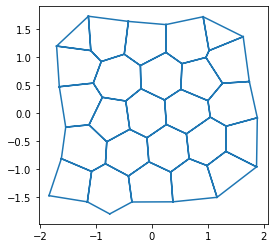

In [26]:
solver = QSSolver()
res = solver.find_energy_min(sheet, geom, model)
fig, ax = sheet_view(sheet, mode="quick")


Let $n_{ij}$ be the number of myosin molecules at edge $ij$, $\sigma_{ij}$ the stress on edge $ij$,  $n_\alpha$ the total number of myosin in cell $\alpha$, and $n_{c\alpha}$ the cytoplasmic concentration of myosin. We have the following differential equation:

$$
\frac{dn_{ij}}{dt} = \frac{- k_d^0}{1 + \exp(\chi\,\sigma_{ij})} n_{ij} + k_a n_{c\alpha}
$$

With 
$$
n_{c\alpha} = n_\alpha - \sum_{kl \in \alpha}n_{kl}
$$
 
This system of coupled ordinary differential equations can be written in the form:
$$
\dot{\mathbf{n}} = A \mathbf{n} + B
$$

Where $\mathbf{n}$ is a vector containing the $N_e$ $n_{ij}$, one per edge, $A$ a $N_e\times N_e$ matrix and B a $N_e$ vector.


For connected components, we have:
$$
B_{ij} = k_a n_\alpha
$$

$$
A_{ij, ij} = -k_d(\sigma_{ij}) - k_a
$$

$$
A_{ij, kl} = - k_a
$$

So most of the work that needs to be donne is finding which terms of A are non-zero...
Then we have:
$$
\begin{eqnarray}
\dot{\mathbf{n}} &=& A \mathbf{n} + B\\
A^{-1}(\dot{\mathbf{n}} - B) &=& \mathbf{n}\\
\end{eqnarray}
$$

And we can solve this system of equations to get $\dot{\mathbf{n}}$.

### Connectivity matrix

This should go in `tyssue.utils.connectivity`

In [34]:
pola_specs = {
    "face" : {
         "myosin" : 10.,
    },
    "edge" : {
         "myosin" : 1., 
         "desorption_rate" : 10., # to be updated with tension
         "absorption_rate" : 1.,
    },
    "settings" : {
         "susceptibility" : 3.0,
         "myo_dependence" : 0.01,
         "max_desorption_rate": 10.
    }
}
sheet.update_specs(pola_specs, reset=True)


from tyssue.solvers.viscous import EulerSolver

def get_myo_matrix(sheet):
    ef_connect = edge_in_face_connectivity(sheet)
    mat = (- np.diag(sheet.edge_df["desorption_rate"])
           - ef_connect * sheet.edge_df['absorption_rate'].values[:, None])
    
    return mat


def edge_projected_stress(sheet, model):
    
    force = -model.compute_gradient(sheet)
    srce_force = sheet.upcast_srce(force)
    trgt_force = sheet.upcast_trgt(force)
    stress = (
        (srce_force - trgt_force) 
        * sheet.edge_df[['u'+c for c in sheet.coords]].values
    ).sum(axis=1)
    
    return stress


def update_chem(sheet, model):
    k_0 = sheet.settings["max_desorption_rate"]
    chi = sheet.settings["susceptibility"]
    myo_dep = sheet.settings["myo_dependence"]
    stress = edge_projected_stress(sheet, model)
    sheet.edge_df["desorption_rate"] = k_0 / (1 + np.exp(chi*stress))
    sheet.edge_df["line_tension"] = myo_dep * sheet.edge_df["myosin"] #/ sheet.edge_df['length']


class EulerProtSolver(EulerSolver):
      
    def ode_func_prot(self):
        A = get_myo_matrix(self.eptm)
        B = self.eptm.upcast_face("myosin").values
        invA = np.linalg.inv(A)
        dot_n = np.linalg.solve(invA, self.eptm.edge_df['myosin']) + B 

        return dot_n
    

    def solve(self, tf, dt, on_topo_change=None, topo_change_args=()):
        """Solves the system of differential equations from the current time
        to tf with steps of dt with a forward Euler method.

        Parameters
        ----------
        tf : float, final time when we stop solving
        dt : float, time step
        on_topo_change : function, optional, default None
             function of `self.eptm`
        topo_change_args : tuple, arguments passed to `on_topo_change`

        """
        for t in np.arange(self.prev_t, tf + dt, dt):
            pos = self.current_pos
            myo = self.eptm.edge_df["myosin"]
            dot_r = self.ode_func(t, pos)


            if self.bounds is not None:
                dot_r = np.clip(dot_r, *self.bounds)
            pos += dot_r * dt
            self.set_pos(pos)
            
            dot_m = self.ode_func_prot()
            self.eptm.edge_df["myosin"] += dot_m * dt
            
            
            self.prev_t = t
            update_chem(self.eptm, self.model)
            
            if self.manager is not None:
                self.manager.execute(self.eptm)
                self.geom.update_all(self.eptm)
                update_chem(self.eptm, self.model)
                self.manager.update()

            if self.eptm.topo_changed:
                log.info("Topology changed")

                if on_topo_change is not None:
                    on_topo_change(*topo_change_args)

                self.history.record(["face", "edge"], t)
                if "cell" in self.eptm.datasets:
                    self.history.record(["cell"], t)
                self.eptm.topo_changed = False
            self.record(t)
            
    

Reseting column myosin of the face dataset with new specs
Reseting column myosin of the edge dataset with new specs
Reseting column desorption_rate of the edge dataset with new specs
Reseting column absorption_rate of the edge dataset with new specs


In [35]:
from tyssue.behaviors.event_manager import EventManager
from tyssue.core.history import History 
# Initiate manager

manager = EventManager('face')
#manager.append(basic_events.reconnect)

#Initiate history to save all columns in all df
history = History(sheet, extra_cols={"face": sheet.face_df.columns,
                                      "edge": list(sheet.edge_df.columns),
                                      "vert": list(sheet.vert_df.columns)
                                     })

# Starting viscous solver
solver = EulerProtSolver(
    sheet,
    geom, 
    model,
    history = history,
    manager = manager,
    bounds = (-sheet.edge_df.length.median()/10,
        sheet.edge_df.length.median()/10)
    )

In [36]:
from tyssue.behaviors.sheet import basic_events
#sheet=save_sheet.copy()
spec={'face_id':16,
      'contractile_increase':1.5,
     'multiple':True}
manager.append(basic_events.contraction, **spec)
manager.update()
sheet.vert_df['viscosity'] = 0.1

sheet.face_df['id'] = sheet.face_df.index

# Solving part... 
dt = 0.1
sheet.settings["dt"] = dt
solver.solve(2, dt)

In [31]:
def custom_view(sheet):
    return sheet_view(
        sheet, 
        mode="2D",
        edge={
            "color": sheet.edge_df['line_tension'],
            "head_width": 0.0, "width": 2.0
        },
        vert={"visible": False}
    )
    

In [20]:
from tyssue.draw import create_gif

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


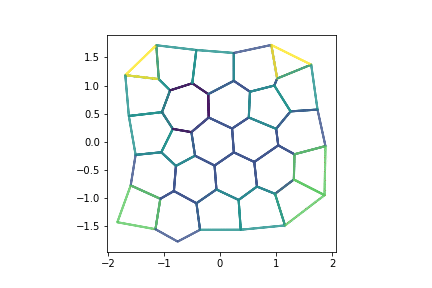

In [37]:
create_gif(solver.history, output="test1.gif", draw_func=custom_view, num_frames=10)

from IPython.display import Image
Image("test1.gif")

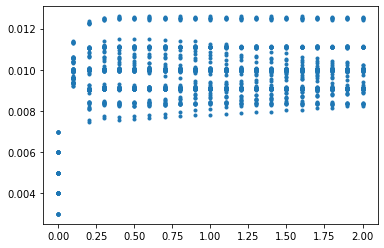

In [38]:
fig, ax = plt.subplots()
edge_h = solver.history.datasets['edge']
ax.plot(edge_h['time'], edge_h['line_tension'], '.')